2025-11-02 15:13:20.288886: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-02 15:13:20.293014: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-02 15:13:20.300211: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-02 15:13:20.318899: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762067600.351572   17697 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762067600.36

449/449 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


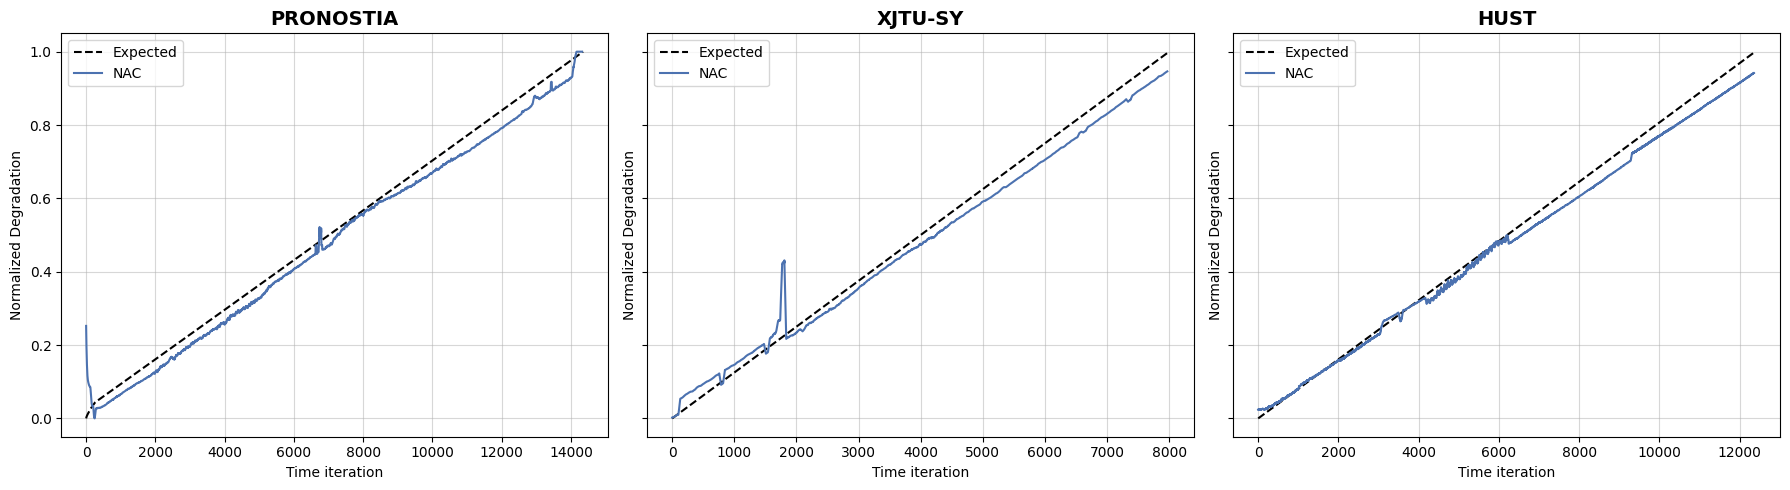

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras._tf_keras.keras.models import Model
from keras._tf_keras.keras.layers import Input, Dense, Reshape, Conv1D
from sklearn.preprocessing import StandardScaler
from utils.preprocess import process_features
from neuronal_attention_circuit import NAC

# Directories
plot_dir = 'plots'
os.makedirs(plot_dir, exist_ok=True)

MODEL_NAME = 'RUL_NAC'
WEIGHTS_DIR = 'model_weights'

# Moving average
def moving_average(data, window_size=30):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')


# Bearings dictionary
bearings = {
    "tf_features_pronostia": "Bearing1_1_features.csv",
    "tf_features_xjtu": "Bearing1_1_features_with_labels.csv",
    "tf_features_hust": "Bearing1_features.csv",
}

bearing_titles = {
    "tf_features_pronostia": "PRONOSTIA",
    "tf_features_xjtu": "XJTU-SY",
    "tf_features_hust": "HUST"
}


# Build model
def build_model(input_shape=(16,)):
    inp = Input(shape=input_shape)
    x = Reshape((1,input_shape[0]))(inp)
    x = Conv1D(32,kernel_size=3, activation='relu', padding='same')(x)
    x = Conv1D(16,kernel_size=2, activation='relu', padding='same')(x)
    x = NAC(d_model=16,num_heads=4,delta_t=1.0,sparsity=0.5,activation='relu',return_sequences=False)(x)
    out = Dense(1, activation='linear')(x)
    return Model(inp, out)


# Model prediction
model = build_model()
model.load_weights(f"{WEIGHTS_DIR}/{MODEL_NAME}.keras")


# Prepare figure
columns = len(bearings)
plt.style.use('seaborn-v0_8-deep')
fig, axes = plt.subplots(1, columns, figsize=(6 * columns, 5), sharey=True)
if columns == 1:
    axes = [axes]

# Loop through bearings
for col_idx, (bearing_folder, bearing_file) in enumerate(bearings.items()):
    df = pd.read_csv(os.path.join(os.getcwd(), bearing_folder, bearing_file))
    
    # Process features
    xh = process_features(np.array(df['Horizontal'].apply(eval).tolist()))
    xv = process_features(np.array(df['Vertical'].apply(eval).tolist()))
    vibration_features = np.concatenate((xh, xv), axis=-1)
    t_data = np.array(df['Time'].values).reshape(-1,1)
    if "Temperature" in df.columns:
        T_data = (df['Temperature'].values + 273.15).reshape(-1, 1)
    else:
        T_data = np.full((len(df), 1), 25 + 273.15)
    X = np.concatenate([vibration_features, t_data, T_data], axis=1)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    if "Degradation" in df.columns:
        y_true = df['Degradation'].values
    else:
        y_true = np.linspace(0, 1, len(df))

    y_pred = model.predict(X).squeeze()
    y_pred = np.clip(y_pred, 0, 1)

    # Plot results
    ax = axes[col_idx]
    ax.plot(y_true, label='Expected', color='black', linestyle='--')
    ax.plot(moving_average(y_pred), label=f'NAC')
    ax.set_title(bearing_titles[bearing_folder], fontweight='bold', fontsize=14)
    ax.set_xlabel('Time iteration')
    ax.set_ylabel('Normalized Degradation')
    ax.grid(alpha=0.5)
    ax.legend()

plt.tight_layout()
plt.savefig(f'{plot_dir}/liquid_attention_single_mode.png', dpi=600)
plt.show()


2025-11-11 05:55:43.878170: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-11 05:55:43.880020: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-11 05:55:43.885396: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-11 05:55:43.901094: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762811743.927871    4960 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762811743.93

449/449 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


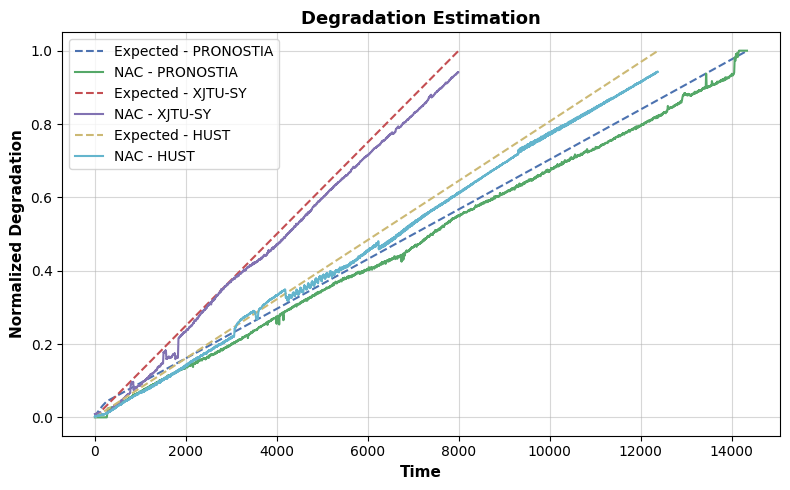

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras._tf_keras.keras.models import Model
from keras._tf_keras.keras.layers import Input, Dense, Reshape, Conv1D
from sklearn.preprocessing import StandardScaler
from utils.preprocess import process_features
from neuronal_attention_circuit import NAC

# Directories
plot_dir = 'plots'
os.makedirs(plot_dir, exist_ok=True)

MODEL_NAME = 'RUL_NAC'
WEIGHTS_DIR = 'model_weights'

# Moving average
def moving_average(data, window_size=10):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')


# Bearings dictionary
bearings = {
    "tf_features_pronostia": "Bearing1_1_features.csv",
    "tf_features_xjtu": "Bearing1_1_features_with_labels.csv",
    "tf_features_hust": "Bearing1_features.csv",
}

bearing_titles = {
    "tf_features_pronostia": "PRONOSTIA",
    "tf_features_xjtu": "XJTU-SY",
    "tf_features_hust": "HUST"
}


# Build model
def build_model(input_shape=(16,)):
    inp = Input(shape=input_shape)
    x = Reshape((1,input_shape[0]))(inp)
    x = Conv1D(32,kernel_size=3, activation='relu', padding='same')(x)
    x = Conv1D(16,kernel_size=2, activation='relu', padding='same')(x)
    x = NAC(d_model=16,num_heads=4, mode='exact',dt=1.0,sparsity=0.5,activation='relu',return_sequences=False)(x)
    out = Dense(1, activation='linear')(x)
    return Model(inp, out)


# Model prediction
model = build_model()
model.load_weights(f"{WEIGHTS_DIR}/{MODEL_NAME}.keras")


plt.style.use('seaborn-v0_8-deep')
plt.figure(figsize=(8, 5))

# Loop through bearings
for bearing_folder, bearing_file in bearings.items():
    df = pd.read_csv(os.path.join(os.getcwd(), bearing_folder, bearing_file))
    
    # Process features
    xh = process_features(np.array(df['Horizontal'].apply(eval).tolist()))
    xv = process_features(np.array(df['Vertical'].apply(eval).tolist()))
    vibration_features = np.concatenate((xh, xv), axis=-1)
    t_data = np.array(df['Time'].values).reshape(-1,1)
    if "Temperature" in df.columns:
        T_data = (df['Temperature'].values + 273.15).reshape(-1, 1)
    else:
        T_data = np.full((len(df), 1), 25 + 273.15)
    X = np.concatenate([vibration_features, t_data, T_data], axis=1)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    if "Degradation" in df.columns:
        y_true = df['Degradation'].values
    else:
        y_true = np.linspace(0, 1, len(df))

    y_pred = model.predict(X).squeeze()
    y_pred = np.clip(y_pred, 0, 1)

    # Plot expected degradation
    plt.plot(y_true, label=f'Expected - {bearing_titles[bearing_folder]}', linestyle='--')
    plt.plot(moving_average(y_pred), label=f'NAC - {bearing_titles[bearing_folder]}')

plt.xlabel('Time', fontsize=11, fontweight='bold')
plt.ylabel('Normalized Degradation', fontsize=11, fontweight='bold')
plt.title('Degradation Estimation', fontweight='bold', fontsize=13)
plt.grid(alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig(f'{plot_dir}/all_bearings_single_plot.png', dpi=600)
plt.show()


In [1]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'
import numpy as np
import tensorflow as tf
import pandas as pd
from utils.preprocess import process_features
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import (
    Input, Dense, Reshape, Conv1D, LSTMCell, GRUCell,
    RNN, SimpleRNNCell, MultiHeadAttention, Flatten, Attention
)
from tensorflow.keras.models import Model
from ncps.tf import LTCCell, CfCCell
from ncps.wirings import FullyConnected
from baseline_cells import CTRNNCell, ODELSTM, PhasedLSTM, GRUODE,ODEformer,CTA
from neuronal_attention_circuit import NAC
from neuronal_attention_circuit import NAC
from NAC_with_Pairwise import NAC_PW
from NAC_with_FC import NAC_FC
from NAC_with_PWFC import NAC_PWFC

base_model_name = 'Degradation_Estimation'
bearings = {
    "tf_features_pronostia": "Bearing1_1_features.csv",
    "tf_features_xjtu": "Bearing1_1_features_with_labels.csv",
    "tf_features_hust": "Bearing1_features.csv",
}
weights_dir = 'model_weights'

def score(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    error = y_pred - y_true

    mask_early = error < 0
    mask_late = error >= 0

    score_early = tf.reduce_sum(tf.exp(-error[mask_early] / 13) - 1)
    score_late = tf.reduce_sum(tf.exp(error[mask_late] / 10) - 1)

    return score_early + score_late

# Wiring for custom cells
wiring = FullyConnected(32)

def build_model(cell_type, input_shape=(16,), num_classes=1):
    inp = Input(shape=input_shape)
    x = Reshape((1, input_shape[0]))(inp)
    x = Conv1D(32, kernel_size=3, activation='relu', padding='same')(x)
    x = Conv1D(16, kernel_size=2, activation='relu', padding='same')(x)

    if cell_type == "RNNCell":
        x = RNN(SimpleRNNCell(16), return_sequences=False)(x)
    elif cell_type == "LSTMCell":
        x = RNN(LSTMCell(16), return_sequences=False)(x)
    elif cell_type == "GRUCell":
        x = RNN(GRUCell(16), return_sequences=False)(x)
    elif cell_type == "LTCCell":
        x = RNN(LTCCell(wiring), return_sequences=False)(x)
    elif cell_type == "CfCCell":
        x = RNN(CfCCell(16), return_sequences=False)(x)
    elif cell_type == "ODELSTM":
        x = RNN(ODELSTM(16), return_sequences=False)(x)
    elif cell_type == "PhasedLSTM":
        x = RNN(PhasedLSTM(16), return_sequences=False)(x)
    elif cell_type == "GRUODE":
        x = RNN(GRUODE(16), return_sequences=False)(x)
    elif cell_type == "CTRNNCell":
        x = RNN(CTRNNCell(16, num_unfolds=5, method='euler'), return_sequences=False)(x)
    elif cell_type == "Attention":
        x = Attention()([x, x])
        x = Flatten()(x)
    elif cell_type == "MultiHeadAttention":
        x = MultiHeadAttention(num_heads=4, key_dim=16)(x, x)
        x = Flatten()(x)
    elif cell_type == "odeformer":
        x = ODEformer(hidden_dim=16, num_heads=8, ff_dim=64)(x)
        x = Flatten()(x)
    elif cell_type == "CTA":
        x = CTA(hidden_size=16)(x)
    elif cell_type == "NAC_Exact":
        x = NAC(d_model=16, num_heads=8, mode='exact',delta_t=1.5,sparsity=0.7, topk=10, activation='relu', return_sequences=False)(x)
    elif cell_type == "NAC_Euler":
        x = NAC(d_model=16, num_heads=8, mode='euler',delta_t=1.5,sparsity=0.7, topk=10, activation='relu',euler_steps=6, return_sequences=False)(x)
    elif cell_type == "NAC_Steady":
        x = NAC(d_model=16, num_heads=8, mode="steady",delta_t=1.5,sparsity=0.7, topk=10, activation='relu',return_sequences=False)(x)
    elif cell_type == "NAC_FC":
        x = NAC_FC(d_model=16, num_heads=8, mode="exact",delta_t=1.5,sparsity=0.7, topk=10, activation='relu',return_sequences=False)(x)
    elif cell_type == "NAC_PW":
        x = NAC_PW(d_model=16, num_heads=8, mode="exact",delta_t=1.5, activation='relu',return_sequences=False)(x)
    elif cell_type == "NAC_PWFC":
        x = NAC_PWFC(d_model=16, num_heads=8, mode="exact",delta_t=1.0, activation='relu',return_sequences=False)(x)
    else:
        raise ValueError(f"Unknown cell type: {cell_type}")

    out = Dense(num_classes, activation='linear')(x)
    return Model(inp, out)

# List of model types
model_types = [
    # "RNNCell", "LSTMCell", "GRUCell",
    # "GRUODE", "CTRNNCell", "PhasedLSTM",
    # "ODELSTM", "CfCCell", "LTCCell",
    # "MultiHeadAttention", "Attention", "odeformer",
    # "NAC_Exact", "NAC_Euler", "NAC_Steady",
    # "NAC_FC","NAC_PW",'NAC_PWFC'
    'CTA'
]

k_folds = 5
results = {}

for feature_dir, filename in bearings.items():
    print(f"\n=== Evaluating dataset: {feature_dir} ===")

    df = pd.read_csv(f"{feature_dir}/{filename}")

    # Process features
    X_h = process_features(np.array(df['Horizontal'].apply(eval).tolist()))
    X_v = process_features(np.array(df['Vertical'].apply(eval).tolist()))
    vibration_features = np.concatenate((X_h, X_v), axis=-1)

    t_data = df['Time'].values.reshape(-1, 1)
    if "Temperature" in df.columns:
        T_data = (df['Temperature'].values + 273.15).reshape(-1, 1)
    else:
        T_data = np.full((len(df), 1), 25 + 273.15)

    if "Degradation" in df.columns:
        y = df['Degradation'].values.reshape(-1, 1)
    else:
        y = np.linspace(0, 1, len(df)).reshape(-1, 1)

    # Combine and normalize
    X = np.concatenate([vibration_features, t_data, T_data], axis=1)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    dataset = tf.data.Dataset.from_tensor_slices((X_scaled, y)).batch(64)

    for cell_type in model_types:
        model_name = f"{base_model_name}_{cell_type}"
        print(f"\nTesting {model_name} on {feature_dir}...")

        fold_score = []

        for fold in range(1, k_folds + 1):
            model = build_model(cell_type, input_shape=(16,))
            weight_file = f"{weights_dir}/{model_name}_fold{fold}.weights.h5"

            if not os.path.exists(weight_file):
                print(f"  Skipping fold {fold}: no weights found at {weight_file}")
                continue

            model.load_weights(weight_file)
            y_true, y_pred = [], []

            for X_batch, y_batch in dataset:
                preds = model.predict(X_batch, verbose=0)
                y_true.append(y_batch.numpy())
                y_pred.append(preds)

            y_true = np.vstack(y_true).squeeze()
            y_pred = np.vstack(y_pred).squeeze()

            fold_s = score(y_true, y_pred).numpy().squeeze()
            fold_score.append(fold_s)

        if fold_score:
            mean_acc = np.mean(fold_score)
            std_acc = np.std(fold_score)
            results[(feature_dir, cell_type)] = {"fold_score": fold_score, "mean": mean_acc, "std": std_acc}

            print(f"Scores: {fold_score}")
            print(f"Mean={mean_acc:.4f}, Std={std_acc:.4f}")

# Final summary
print("\n=== Final Results ===")
for (feature_dir, cell_type), data in results.items():
    print(f"{feature_dir} - {base_model_name}_{cell_type}: Mean={data['mean']:.4f}, Std={data['std']:.4f}")


2025-11-12 03:58:01.552518: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-12 03:58:01.554161: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-12 03:58:01.558736: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-12 03:58:01.572218: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762891081.595435   30163 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762891081.60


=== Evaluating dataset: tf_features_pronostia ===


W0000 00:00:1762891085.698229   30163 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...



Testing Degradation_Estimation_CTA on tf_features_pronostia...


2025-11-12 03:58:23.912879: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-11-12 03:58:45.178297: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-11-12 03:59:20.899989: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Scores: [34.69617, 42.085823, 33.362015, 33.30042, 32.34243]
Mean=35.1574, Std=3.5443

=== Evaluating dataset: tf_features_xjtu ===

Testing Degradation_Estimation_CTA on tf_features_xjtu...


2025-11-12 04:00:10.025703: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Scores: [23.78261, 22.902054, 25.992043, 24.8418, 21.776936]
Mean=23.8591, Std=1.4678

=== Evaluating dataset: tf_features_hust ===

Testing Degradation_Estimation_CTA on tf_features_hust...
Scores: [42.64481, 38.686752, 29.75772, 40.218666, 40.749596]
Mean=38.4115, Std=4.5082

=== Final Results ===
tf_features_pronostia - Degradation_Estimation_CTA: Mean=35.1574, Std=3.5443
tf_features_xjtu - Degradation_Estimation_CTA: Mean=23.8591, Std=1.4678
tf_features_hust - Degradation_Estimation_CTA: Mean=38.4115, Std=4.5082
